In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
from datetime import datetime
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM


from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [23]:
#load dataset
sent = pd.read_json('sentiment/fb_parse.json')
stock = pd.read_json('nasdaq/FB.json', convert_dates=['Time'])#, engine='python')#, skipfooter=3)


In [24]:
print((stock['Time'][0]))
print((sent['date'][0]))
print(sent.head())


2012-06-01 09:00:00
2011-01-09 00:00:00
   bearish  bearish_percent  bullish  bullish_percent       date  none  total
0        0              0.0        1            100.0 2011-01-09     7      8
1        0              0.0        1            100.0 2012-02-02   244    245
2        0              0.0        1            100.0 2012-02-03   104    105
3        0              0.0        1            100.0 2012-02-05    16     17
4        0              0.0        1            100.0 2012-02-08    40     41


In [25]:
stock['Time_nohour'] = stock['Time'] 
stock['Time_nohour'] = stock['Time_nohour'].apply((lambda ts: pd.Timestamp(datetime(ts.year, ts.month, ts.day) ))) 
                                
print(stock['Time_nohour'])


0      2012-06-01
1      2012-06-01
2      2012-06-01
3      2012-06-01
4      2012-06-01
5      2012-06-01
6      2012-06-01
7      2012-06-01
8      2012-06-04
9      2012-06-04
10     2012-06-04
11     2012-06-04
12     2012-06-04
13     2012-06-04
14     2012-06-04
15     2012-06-04
16     2012-06-05
17     2012-06-05
18     2012-06-05
19     2012-06-05
20     2012-06-05
21     2012-06-05
22     2012-06-05
23     2012-06-05
24     2012-06-06
25     2012-06-06
26     2012-06-06
27     2012-06-06
28     2012-06-06
29     2012-06-06
          ...    
8583   2016-09-13
8584   2016-09-13
8585   2016-09-13
8586   2016-09-13
8587   2016-09-13
8588   2016-09-13
8589   2016-09-14
8590   2016-09-14
8591   2016-09-14
8592   2016-09-14
8593   2016-09-14
8594   2016-09-14
8595   2016-09-14
8596   2016-09-14
8597   2016-09-15
8598   2016-09-15
8599   2016-09-15
8600   2016-09-15
8601   2016-09-15
8602   2016-09-15
8603   2016-09-15
8604   2016-09-15
8605   2016-09-16
8606   2016-09-16
8607   201

In [26]:
dataframe = stock
dataframe_merge = pd.merge(stock, sent, left_on='Time_nohour', right_on='date')
#print(dataframe)

In [27]:
dataset = (0.5*(dataframe['First'] + dataframe['Last'])).values
sent_dataset = dataframe_merge['bullish_percent'].values
print(dataset)

[  28.51    28.205   27.97  ...,  128.545  128.825  129.065]


In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
sent_scaler =  MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
sent_dataset = sent_scaler.fit_transform(sent_dataset)

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

In [29]:
def rnnDataPrep(data, n_prev):
    X_data, y_data = [], []
    #naive version
    for i in range(n_prev, len(data)):#11th entry, previous 10 are kept
        X_data.append(data[i - (n_prev):i].tolist())
    
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))

def rnnDataPrepSent(data, n_prev):
    X_data, y_data = [], []
    #naive version
    for i in range(n_prev, len(data)):#11th entry, previous 10 are kept
        X_data.append(np.append(data[i - (n_prev):i], sent_dataset[i-1]) .tolist())
    
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))
    

temp_x, temp_y = rnnDataPrep(dataset, 10)
#print(temp_x)
print (temp_x.shape, temp_y.shape)


(8603, 10, 1) (8603,)


In [30]:
#Splitting data into training and validation


ttR = 0.6 #train test Ratio
#n = int(ttR * len(dataset))

lb = 5 #lb stands for look back, 
X, y = rnnDataPrep(dataset, lb)
n = int(ttR * len(X))
#train, test = X#dataset[:int(ttR * len(dataset))], dataset[int(ttR * len(dataset)):] #split chronologically

X_train, y_train = X[:n], y[:n]#rnnDataPrep(train, lb)
X_test, y_test = X[n:], y[n:]#rnnDataPrep(test, lb)


#print(train.shape, test.shape)
print(len(dataset))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


8613
(5164, 5, 1) (3444, 5, 1)
(5164,) (3444,)


In [32]:
# create and fit the LSTM network

def build_model_multilayer():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def build_model_unilayer():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=4))
    model.add(Dense(output_dim=1))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model
    
model_unilayer = build_model_unilayer()
model_unilayer.fit(X_train, y_train, nb_epoch=20, batch_size=1, verbose=2)


Compilation Time :  0.004864931106567383
Epoch 1/20
7s - loss: 0.0027
Epoch 2/20
7s - loss: 4.0945e-05
Epoch 3/20
7s - loss: 3.2460e-05
Epoch 4/20
7s - loss: 2.7412e-05
Epoch 5/20
7s - loss: 2.4789e-05
Epoch 6/20
7s - loss: 2.1180e-05
Epoch 7/20
7s - loss: 1.9609e-05
Epoch 8/20
7s - loss: 1.8291e-05
Epoch 9/20
7s - loss: 1.6980e-05
Epoch 10/20
7s - loss: 1.6072e-05
Epoch 11/20
7s - loss: 1.5347e-05
Epoch 12/20
7s - loss: 1.4887e-05
Epoch 13/20
7s - loss: 1.4634e-05
Epoch 14/20
7s - loss: 1.4281e-05
Epoch 15/20
8s - loss: 1.4003e-05
Epoch 16/20
8s - loss: 1.3987e-05
Epoch 17/20
7s - loss: 1.3929e-05
Epoch 18/20
7s - loss: 1.3875e-05
Epoch 19/20
7s - loss: 1.3757e-05
Epoch 20/20
7s - loss: 1.3740e-05


In [33]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))

trainScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_test, y_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

baseline test score = 19.64 RMSE
train score = 18.15 RMSE
test score = 19.04 RMSE


In [186]:
#PURE SENT FITTING
sent_lb = 1

X_sent, y_sent = rnnDataPrep(sent_dataset, sent_lb)[0], 0.5*(dataframe_merge['First'] + dataframe_merge['Last'])
n = int(ttR * len(X_sent))
#train, test = X_sent#dataset[:int(ttR * len(dataset))], dataset[int(ttR * len(dataset)):] #split chronologically_sent

X_sent_train, y_sent_train = X_sent[:n], y_sent[:n]
X_sent_test, y_sent_test = X_sent[n:], y_sent[n:]


In [ ]:
model_sent = build_model_unilayer()

model_sent.fit(X_sent_train, y_sent_train, nb_epoch=50, batch_size=1, verbose=2)

Compilation Time :  0.009747743606567383
Epoch 1/50
11s - loss: 230590.3747
Epoch 2/50
12s - loss: 206262.0136
Epoch 3/50


In [190]:
#===============================================================

baseline_testScore = sent_scaler.inverse_transform(np.array([[mean_squared_error(y_sent_test, y_sent_test)**.5]]))

trainScore = sent_scaler.inverse_transform(np.array([[model_sent.evaluate(X_sent_train, y_sent_train, verbose=0)**.5]]))
testScore = sent_scaler.inverse_transform(np.array([[model_sent.evaluate(X_sent_test, y_sent_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

Exception: Input arrays should have the same number of samples as target arrays. Found 4425 input samples and 4426 target samples.

In [34]:
# generate predictions for training
y_train_pred = model_unilayer.predict(X_train)
y_test_pred = model_unilayer.predict(X_test)

#y_sent_train_pred = model_sent.predict(X_sent_train)
#y_sent_test_pred = model_sent.predict(X_sent_test)

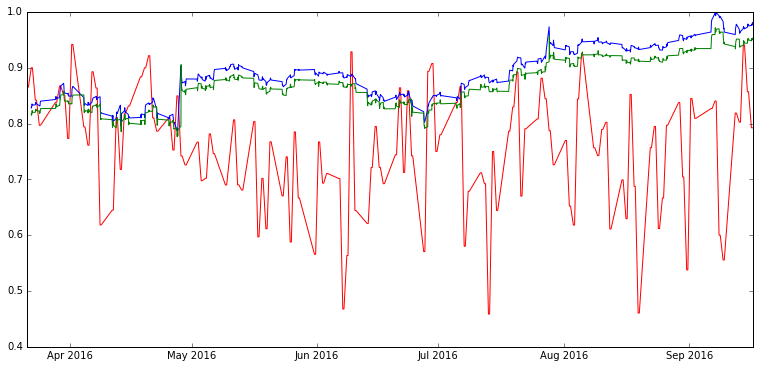

In [36]:
nn = 1000

plt.figure(figsize=(13, 6))

plt.plot(dataframe_merge['Time'][3:][-nn:], sent_dataset[3:][-nn:], color='red')
#plt.plot(dataframe_merge['Time'][3:][-nn:], y_sent_test_pred[3:][-nn:]/20, color='purple')

plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], '-', ms=5, color='blue')
#plt.plot(dataframe['Time'][3:][:n], y_train_pred, 'r')
plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:], '-', ms=5, color='green')

#plt.plot(dataframe['Time'][3:][n:][-nn:], y_sent_test_pred[-nn:], '-', ms=5, color='red')